# GTFS Stops

## Create a geopandas geodataframe from a GTFS feed

Here is a url for a GTFS data feed. Let's turn it into a flexible geodataframe!

In [34]:
url = 'http://web.mta.info/developers/data/nyct/bus/google_transit_brooklyn.zip'

We first have to import some modules from the [Python standard library](https://docs.python.org/3/library/)

We also have to import some third party modules.

Add the *conda-forge* channel to your base channel by running:

`conda config --add channels conda-forge`

You can then create an environment with these dependencies by running: 

`conda create --name geo_env --file package-list.txt`

In [35]:
import requests
from zipfile import ZipFile
from io import StringIO, BytesIO

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import geometry

Define a function for converting gtfs zipfiles into pandas dataframes. The dataframes are stored in a python dictionary.

In [36]:
def gtfsZipToDataframes(zip):
    # create a dictionary to store the dataframes
    dataframes = {}

    # check if the zipfile has the required files
    required_files = ['agency.txt', 'stops.txt', 'routes.txt', 'trips.txt', 'stop_times.txt']

    has_required_files = [req_file in (file.filename for file in zip.filelist) for req_file in required_files]

    if all(has_required_files):
        # also check if there are any files not part of the gtfs standard and alert the user
        standard_files = required_files + [
            'shapes.txt', 'stop_times.txt', 'calendar.txt', 'calendar_dates.txt',
            'fare_attributes.txt', 'fare_rules.txt', 'frequencies.txt', 'transfers.txt',
            'pathways.txt', 'levels.txt', 'translations.txt', 'feed_info.txt', 'attributions.txt'
        ]

        # for each file in the list
        for file in zip.filelist:
            file_name = file.filename
            # check that it is one of the standard files
            if any(standard_file_name == file_name for standard_file_name in standard_files):
                # open the file, read the data into a pandas dataframe, and add that to the dictionary
                with zip.open(file_name) as f:
                    bytes = f.read()
                    s = str(bytes, 'utf-8')
                    data = StringIO(s)
                    df = pd.read_csv(data, low_memory=False)
                    name = file_name.split('.txt')[0]
                    dataframes[name] = df
            else:
                print('%s is not part of the gtfs specification!' % file_name)
    else:
        missing_files = [required_files[i] for i, has_file in enumerate(has_required_files) if not has_file]
        raise Exception('GTFS feed does not have the required file(s): %s' % ' '.join(missing_files))

    return dataframes

Run the function and list the resulting dataframes. The number of dataframes will vary between different gtfs sources.

*You can also work with a local copy of the data for improved performance*

In [37]:
# zip = zipfile.ZipFile('data/nyc_subways.zip')
r = requests.get(url)
zip = ZipFile(BytesIO(r.content))
gtfs_dataframes = gtfsZipToDataframes(zip)
list(gtfs_dataframes)

['agency',
 'calendar',
 'calendar_dates',
 'routes',
 'shapes',
 'stops',
 'stop_times',
 'trips']

Let's take a look at the agency dataframe

In [38]:
agency = gtfs_dataframes['agency']
agency.head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234


Here's the routes dataframe

In [39]:
routes = gtfs_dataframes['routes']
routes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color
0,B1,MTA NYCT,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF
1,B11,MTA NYCT,B11,Sunset Park - Midwood,via 49th & 50th St / Avenue J,3,006CB7,FFFFFF
2,B12,MTA NYCT,B12,Lefferts Gardens - East New York,via Clarkson Av / Empire Blvd / East New York Av,3,6CBE45,FFFFFF
3,B13,MTA NYCT,B13,Spring Creek - Wyckoff Hospital,via Crescent St / Jamaica Av / Wyckoff Av,3,FAA61A,FFFFFF
4,B14,MTA NYCT,B14,Spring Creek - Crown Heights,via Sutter Av / Pitkin Av,3,00AEEF,FFFFFF


We can join the agency and routes dataframes on the agency_id column

In [40]:
agency_routes = agency.join(
    routes.set_index('agency_id'),
    on='agency_id'
)
agency_routes.head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,route_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B11,B11,Sunset Park - Midwood,via 49th & 50th St / Avenue J,3,006CB7,FFFFFF
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B12,B12,Lefferts Gardens - East New York,via Clarkson Av / Empire Blvd / East New York Av,3,6CBE45,FFFFFF
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B13,B13,Spring Creek - Wyckoff Hospital,via Crescent St / Jamaica Av / Wyckoff Av,3,FAA61A,FFFFFF
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B14,B14,Spring Creek - Crown Heights,via Sutter Av / Pitkin Av,3,00AEEF,FFFFFF


Here's a look at the trips datframe

In [41]:
trips = gtfs_dataframes['trips']
trips.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,B82+,EN_C1-Weekday,EN_C1-Weekday-028500_SBS82_901,SELECT BUS BENSNHRST BAY 38 via FLATLNDS,1,SBS821511
1,B82+,EN_C1-Weekday,EN_C1-Weekday-034800_SBS82_901,SELECT BUS SPRING CRK SEAVIEW via KINGS,0,SBS821510
2,B82+,EN_C1-Weekday,EN_C1-Weekday-040300_SBS82_901,SELECT BUS BENSNHRST BAY 38 via FLATLNDS,1,SBS821511
3,B82+,EN_C1-Weekday,EN_C1-Weekday-048000_SBS82_901,SELECT BUS SPRING CRK SEAVIEW via KINGS,0,SBS821510
4,B82+,EN_C1-Weekday,EN_C1-Weekday-029900_SBS82_902,SELECT BUS BENSNHRST BAY 38 via FLATLNDS,1,SBS821511


We can join the trips and routes dataframes on the route_id

In [42]:
routes_trips = agency_routes.join(
    trips.set_index('route_id'),
    on='route_id'
)
routes_trips.head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,route_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,service_id,trip_id,trip_headsign,direction_id,shape_id
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-009800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-013800_B1_2,MANHATTAN BEACH KINGSBORO CC,1.0,B10016
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-017800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-021800_B1_2,MANHATTAN BEACH KINGSBORO CC,1.0,B10016
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,3,00AEEF,FFFFFF,UP_C1-Weekday,UP_C1-Weekday-025800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016


This is the stop_times dataframe. It links the stops to the trips.

In [43]:
stop_times = gtfs_dataframes['stop_times']
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,EN_C1-Weekday-028500_SBS82_901,04:45:00,04:45:00,304083,1,0,0
1,EN_C1-Weekday-028500_SBS82_901,04:47:37,04:47:37,304085,2,0,0
2,EN_C1-Weekday-028500_SBS82_901,04:49:08,04:49:08,308865,3,0,0
3,EN_C1-Weekday-028500_SBS82_901,04:51:39,04:51:39,306950,4,0,0
4,EN_C1-Weekday-028500_SBS82_901,04:53:54,04:53:54,304092,5,0,0


We can join the shapes and trips on the shape_id column. Let's also drop a bunch of columns that no longer need.

In [54]:
trip_stop_times = routes_trips.join(
    stop_times.set_index('trip_id'),
    on='trip_id'
)

trip_stop_times.drop(
    [
#         'service_id',
#         'trip_id',
#         'trip_headsign',
#         'direction_id',
        'block_id',
        'shape_dist_traveled'
    ], 
    axis=1,
    errors='ignore',
    inplace=True
)
trip_stop_times.head()

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,route_id,route_short_name,route_long_name,route_desc,...,trip_id,trip_headsign,direction_id,shape_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,...,UP_C1-Weekday-009800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016,01:38:00,01:38:00,308644.0,1.0,1.0,1.0
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,...,UP_C1-Weekday-009800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016,01:38:38,01:38:38,301614.0,2.0,0.0,0.0
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,...,UP_C1-Weekday-009800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016,01:39:14,01:39:14,301615.0,3.0,0.0,0.0
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,...,UP_C1-Weekday-009800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016,01:39:56,01:39:56,305511.0,4.0,0.0,0.0
0,MTA NYCT,MTA New York City Transit,http://www.mta.info,America/New_York,en,718-330-1234,B1,B1,Bay Ridge - Manhattan Beach,via 86th St / Ocean Pkwy,...,UP_C1-Weekday-009800_B1_1,MANHATTAN BEACH KINGSBORO CC,1.0,B10016,01:40:28,01:40:28,305512.0,5.0,0.0,0.0


Here's the stops dataframe. This contains the spatial data describing the location of each stop.

In [55]:
stops = gtfs_dataframes['stops']
stops.head()

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,300000,ORIENTAL BL/MACKENZIE ST,NaN,40.578350,-73.940029,NaN,NaN,0,NaN
1,300002,ORIENTAL BL/JAFFRAY ST,NaN,40.578066,-73.943029,NaN,NaN,0,NaN
2,300003,ORIENTAL BL/HASTINGS ST,NaN,40.577909,-73.944643,NaN,NaN,0,NaN
3,300004,ORIENTAL BL/FALMOUTH ST,NaN,40.577718,-73.946200,NaN,NaN,0,NaN
4,300006,ORIENTAL BL/DOVER ST,NaN,40.577353,-73.949552,NaN,NaN,0,NaN


We can join the stops and the stop times on the stop_id column

In [56]:
trip_stops = stops.join(
    trip_stop_times.set_index('stop_id'),
    on='stop_id'
)
trip_stops.head()

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,agency_id,...,service_id,trip_id,trip_headsign,direction_id,shape_id,arrival_time,departure_time,stop_sequence,pickup_type,drop_off_type
0,300000,ORIENTAL BL/MACKENZIE ST,NaN,40.57835,-73.940029,NaN,NaN,0,NaN,MTA NYCT,...,UP_C1-Weekday,UP_C1-Weekday-118300_B1_23,BAY RIDGE 4 AV,0.0,B10018,19:43:00,19:43:00,2.0,0.0,0.0
0,300000,ORIENTAL BL/MACKENZIE ST,NaN,40.57835,-73.940029,NaN,NaN,0,NaN,MTA NYCT,...,UP_C1-Weekday,UP_C1-Weekday-119300_B1_34,BAY RIDGE 4 AV,0.0,B10018,19:53:00,19:53:00,2.0,0.0,0.0
0,300000,ORIENTAL BL/MACKENZIE ST,NaN,40.57835,-73.940029,NaN,NaN,0,NaN,MTA NYCT,...,UP_C1-Weekday,UP_C1-Weekday-120300_B1_30,BAY RIDGE 4 AV,0.0,B10018,20:03:00,20:03:00,2.0,0.0,0.0
0,300000,ORIENTAL BL/MACKENZIE ST,NaN,40.57835,-73.940029,NaN,NaN,0,NaN,MTA NYCT,...,UP_C1-Weekday,UP_C1-Weekday-121300_B1_32,BAY RIDGE 4 AV,0.0,B10018,20:13:00,20:13:00,2.0,0.0,0.0
0,300000,ORIENTAL BL/MACKENZIE ST,NaN,40.57835,-73.940029,NaN,NaN,0,NaN,MTA NYCT,...,UP_C1-Weekday,UP_C1-Weekday-122300_B1_35,BAY RIDGE 4 AV,0.0,B10018,20:23:00,20:23:00,2.0,0.0,0.0


Let's list the unique route ids

In [57]:
list(routes.route_id.unique())

['B1',
 'B11',
 'B12',
 'B13',
 'B14',
 'B15',
 'B16',
 'B17',
 'B2',
 'B20',
 'B24',
 'B25',
 'B26',
 'B3',
 'B31',
 'B32',
 'B35',
 'B36',
 'B37',
 'B38',
 'B39',
 'B4',
 'B41',
 'B42',
 'B43',
 'B44',
 'B44+',
 'B45',
 'B46',
 'B46+',
 'B47',
 'B48',
 'B49',
 'B52',
 'B54',
 'B57',
 'B6',
 'B60',
 'B61',
 'B62',
 'B63',
 'B64',
 'B65',
 'B67',
 'B68',
 'B69',
 'B7',
 'B70',
 'B74',
 'B8',
 'B82',
 'B82+',
 'B83',
 'B84',
 'B9',
 'B91',
 'B91A',
 'B92',
 'B98V',
 'B99',
 'BX3',
 'BX4',
 'BX4A',
 'BX5',
 'BX6',
 'BX6+',
 'BX7',
 'BX8',
 'BX9',
 'BX1',
 'BX10',
 'BX11',
 'BX12',
 'BX12+',
 'BX13',
 'BX15',
 'BX16',
 'BX17',
 'BX18',
 'BX19',
 'BX2',
 'BX20',
 'BX21',
 'BX22',
 'BX24',
 'BX25',
 'BX26',
 'BX27',
 'BX28',
 'BX29',
 'BX30',
 'BX31',
 'BX32',
 'BX33',
 'BX34',
 'BX35',
 'BX36',
 'BX38',
 'BX39',
 'BX40',
 'BX41',
 'BX41+',
 'BX42',
 'BX46',
 'BX99',
 'EBUS',
 'SHGRD',
 'SHNRD',
 'SIR5',
 'SHUT5',
 'GHAS',
 'MVAS',
 'MQAS',
 'OFAS',
 'OHAS',
 'ENAS',
 'FBAS',
 'GAAS',
 'JGA

Now for the fun part... We're going to transform this data into a geodataframe. Additional notes describing each step are provided in the code comments.

In [58]:
# create a list to store the stops for each route
route_list = []

# for each unique route_id
# for route_id in routes.route_id.unique():
for route_id in ['B35']:
    
    # get the route shapes
    route_stops = trip_stops.loc[trip_stops.route_id == route_id]
    
    # check if there are stops
    if route_stops.size > 0:
        
        # get the unique stop points for the route
        route_stops = route_stops.drop_duplicates(
#             subset=['stop_id', 'stop_lat', 'stop_lon'],
            subset=['stop_id', 'stop_lat', 'stop_lon', 'shape_id'],
            keep='first'
        ).reset_index(drop=True)

        # add a shapely geometry column
        route_stops['geometry'] = route_stops.apply(
            lambda row: geometry.Point(row.stop_lon, row.stop_lat),
            axis=1
        )
        
        # we no longer need the original lat lon columns, so we can drop them
        route_stops.drop(
            [
                'stop_lat',
                'stop_lon'
            ], 
            axis=1,
            inplace=True
        )

        # append the stops to the route list
        route_list.append(route_stops)

# create a geodataframe from the route list
network_stops = gpd.GeoDataFrame(pd.concat(route_list)).reset_index(drop=True)
network_stops.set_crs(4236, inplace=True) # set the spatial reference
network_stops.to_file('data/b35_stops.geojson', driver="GeoJSON")
network_stops.to_crs(epsg=3857, inplace=True) # project the coordinates
network_stops.head()

,stop_id,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,agency_id,agency_name,agency_url,...,trip_id,trip_headsign,direction_id,shape_id,arrival_time,departure_time,stop_sequence,pickup_type,drop_off_type,geometry
0,301052,HEGEMAN AV/WATKINS ST,NaN,NaN,NaN,0,NaN,MTA NYCT,MTA New York City Transit,http://www.mta.info,...,JG_C1-Weekday-118000_B35_555,LIMITED SUNSET PARK 1 AV via CHURCH AV,1.0,B350204,19:40:00,19:40:00,1.0,0.0,0.0,POINT (-8228072.692 4961206.247)
1,301052,HEGEMAN AV/WATKINS ST,NaN,NaN,NaN,0,NaN,MTA NYCT,MTA New York City Transit,http://www.mta.info,...,JG_C1-Weekday-118600_B35_558,McDONALD AV via CHURCH AV,1.0,B350209,19:46:00,19:46:00,1.0,0.0,0.0,POINT (-8228072.692 4961206.247)
2,301052,HEGEMAN AV/WATKINS ST,NaN,NaN,NaN,0,NaN,MTA NYCT,MTA New York City Transit,http://www.mta.info,...,JG_C1-Weekday-139000_B35_565,SUNSET PARK 1 AV via CHURCH,1.0,B350211,23:10:00,23:10:00,1.0,0.0,0.0,POINT (-8228072.692 4961206.247)
3,301053,HEGEMAN AV/THATFORD AV,NaN,NaN,NaN,0,NaN,MTA NYCT,MTA New York City Transit,http://www.mta.info,...,JG_C1-Weekday-118600_B35_558,McDONALD AV via CHURCH AV,1.0,B350209,19:46:44,19:46:44,2.0,0.0,0.0,POINT (-8228213.944 4961178.942)
4,301053,HEGEMAN AV/THATFORD AV,NaN,NaN,NaN,0,NaN,MTA NYCT,MTA New York City Transit,http://www.mta.info,...,JG_C1-Weekday-139000_B35_565,SUNSET PARK 1 AV via CHURCH,1.0,B350211,23:10:33,23:10:33,2.0,0.0,0.0,POINT (-8228213.944 4961178.942)


Check if there is a route color and set a default, if none.

In [59]:
default_color = '000000'
if 'route_color' in network_stops.columns:
    network_stops.route_color.fillna(default_color, inplace=True)
else:
    network_stops.route_color = default_color

Now we can plot the geodataframe

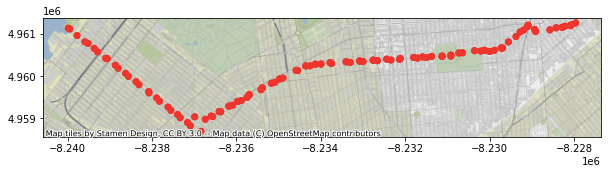

In [60]:
ax = network_stops.plot(color='#' + network_stops.route_color, figsize=(10, 10))
ctx.add_basemap(ax)
plt.show()

Contextily provides a number of basemap sources

In [61]:
list(ctx.providers.keys())

['OpenStreetMap',
 'OpenSeaMap',
 'OpenPtMap',
 'OpenTopoMap',
 'OpenRailwayMap',
 'OpenFireMap',
 'SafeCast',
 'Thunderforest',
 'OpenMapSurfer',
 'Hydda',
 'MapBox',
 'Stamen',
 'Esri',
 'OpenWeatherMap',
 'HERE',
 'FreeMapSK',
 'MtbMap',
 'CartoDB',
 'HikeBike',
 'BasemapAT',
 'nlmaps',
 'NASAGIBS',
 'NLS',
 'JusticeMap',
 'Wikimedia',
 'GeoportailFrance',
 'OneMapSG']

Let's take a look at CartoDB

In [62]:
list(ctx.providers.CartoDB.keys())

['Positron',
 'PositronNoLabels',
 'PositronOnlyLabels',
 'DarkMatter',
 'DarkMatterNoLabels',
 'DarkMatterOnlyLabels',
 'Voyager',
 'VoyagerNoLabels',
 'VoyagerOnlyLabels',
 'VoyagerLabelsUnder']

The Positron tileset gives us a nice light background so we can easily see our routes.

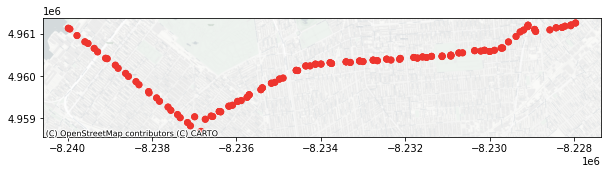

In [63]:
ax = network_stops.plot(color='#' + network_stops.route_color, figsize=(10, 10))
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()